In [82]:
import os
import cv2
import gc
import pandas as pd
import numpy as np
import pydicom
from pydicom.data import get_testdata_file
import matplotlib.pyplot as plt


PATH = r'C:\Users\pka\kaggle\melanoma\input\siim-isic-melanoma-classification'
PATH_JPEG = r'C:\Users\pka\kaggle\melanoma\input\siim-isic-melanoma-classification\jpeg\train'
PATH_DCM = r'C:\Users\pka\kaggle\melanoma\input\siim-isic-melanoma-classification\train'

## Description

В этом конкурсе вы обнаружите меланому на изображениях поражений кожи. В частности, вы будете использовать изображения одного и того же пациента и определить, какие из них могут представлять меланому.

In this competition, you’ll identify melanoma in images of skin lesions. In particular, you’ll use images within the same patient and determine which are likely to represent a melanoma.

## Data format

Изображения предоставляются в формате DICOM. Доступ к нему можно получить с помощью общедоступных библиотек, таких как pydicom, и содержит как изображения, так и метаданные. Это широко используемый формат данных медицинской визуализации.

Изображения также предоставляются в формате JPEG и TFRecord (соответственно в каталогах jpeg и tfrecords). Размер изображений в формате TFRecord был изменен до 1024x1024.

Метаданные также предоставляются вне формата DICOM в файлах CSV. Смотрите раздел Столбцы для описания.

## Predict?

Вы предсказываете двоичную цель для каждого изображения. Ваша модель должна прогнозировать вероятность (с плавающей точкой) между 0,0 и 1,0, что поражение на изображении является злокачественным (цель).

В обучающих данных train.csv значение 0 обозначает доброкачественные, а 1 обозначает злокачественные.

### List files:
- train.csv - тренировочный набор
- test.csv - тестовый набор
- sample_submission.csv - файл с примерами представления в правильном формате

Columns:
- image_name - уникальный идентификатор, указывает на имя файла соответствующего изображения DICOM
- Patient_id - уникальный идентификатор пациента
- пол - пол пациента (если неизвестно, будет пустым)
- age_approx - приблизительный возраст пациента на момент визуализации
- anatom_site_general_challenge - расположение отображаемого сайта
- диагноз - подробная диагностическая информация (только поезд)
- benign_malignant - показатель злокачественности визуализированного поражения
- target - бинаризованная версия целевой переменной


Plan

1. stat age, sex stat
2. stat target
3. see image (ccanser/ or no)
4. what is maligant?, in test (доброкачественная(bening)/злокачественный(maligant))
5. see test
6. see test image
7. what is site general?


after we need answer what is format use? what size image?

make image, add make first model

In [ ]:
benign       32542
malignant

In [37]:
df = pd.read_csv(os.path.join(PATH, 'train.csv'))
test= pd.read_csv(os.path.join(PATH, 'test.csv'))

In [9]:
df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  
0   unknown           benign       0  
1   unknown           benign       0  
2     nevus           benign       0  
3   unknown           benign       0  
4   unknown           benign       0

In [38]:
test.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge
0  ISIC_0052060  IP_3579794    male        70.0                           NaN
1  ISIC_0052349  IP_7782715    male        40.0               lower extremity
2  ISIC_0058510  IP_7960270  female        55.0                         torso
3  ISIC_0073313  IP_6375035  female        50.0                         torso
4  ISIC_0073502  IP_0589375  female        45.0               lower extremity

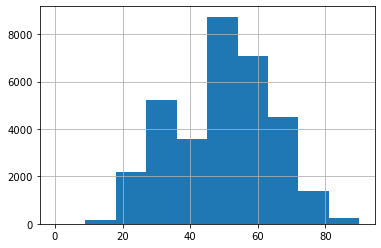

In [35]:
df['age_approx'].hist()

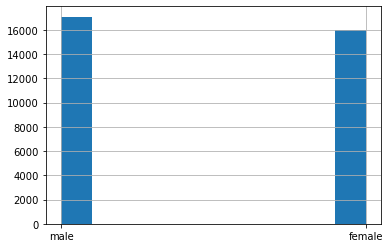

In [31]:
print(df['target'].value_counts())
print('Percent canser: %.3f' % (100 * df['target'].value_counts()[1] / df['target'].value_counts()[0]))

0    32542
1      584
Name: target, dtype: int64
Percent canser: 1.795


In [36]:
df.benign_malignant.value_counts()

benign       32542
malignant      584
Name: benign_malignant, dtype: int64

In [40]:
df.anatom_site_general_challenge.value_counts()

torso              16845
lower extremity     8417
upper extremity     4983
head/neck           1855
palms/soles          375
oral/genital         124
Name: anatom_site_general_challenge, dtype: int64

In [43]:
"""
голова / шея 
нижняя конечность                       
оральный / генитальный 
ладони / подошвы 
торс
верхняя конечность
"""

df.groupby(['anatom_site_general_challenge', 'target'])['target'].count()

anatom_site_general_challenge  target
head/neck                      0          1781
                               1            74
lower extremity                0          8293
                               1           124
oral/genital                   0           120
                               1             4
palms/soles                    0           370
                               1             5
torso                          0         16588
                               1           257
upper extremity                0          4872
                               1           111
Name: target, dtype: int64

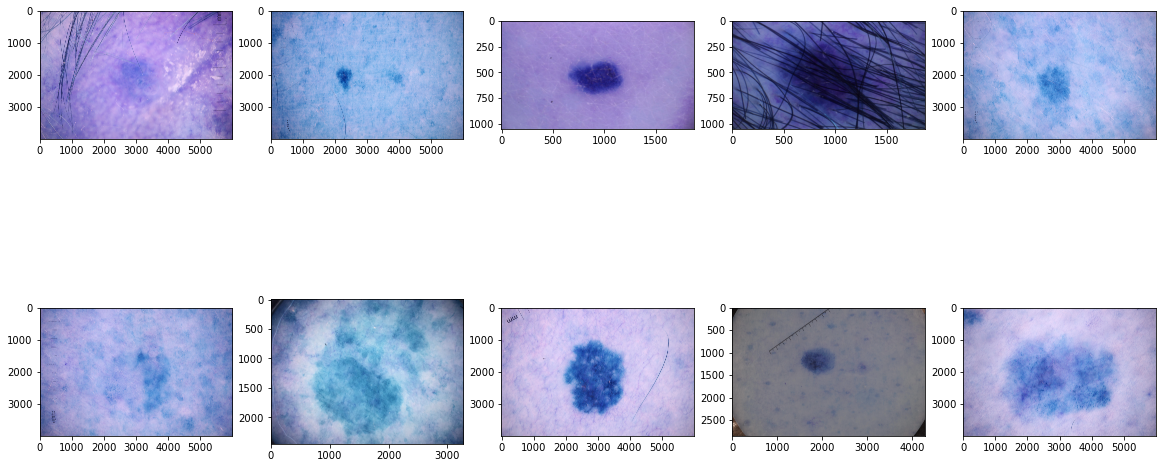

In [156]:
fig, (ax1,ax2) = plt.subplots(2, 5, figsize=(20,10))
for i in range(1, 6):      
    name = df.image_name[i-1]    
    image =  os.path.join(PATH_JPEG, f'{name}.jpg')
    img = cv2.imread(image)
    ax1[i-1].imshow(img)
for i in range(1, 6):      
    name = df[df.target == 1].image_name.values[i-1]    
    image =  os.path.join(PATH_JPEG, f'{name}.jpg')
    img = cv2.imread(image)
    ax2[i-1].imshow(img)

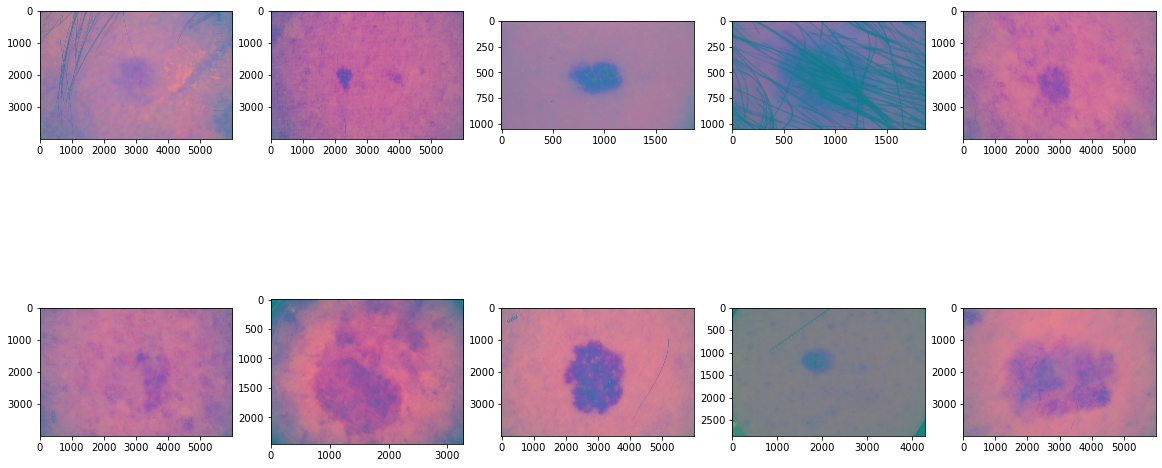

In [160]:
fig, (ax1,ax2) = plt.subplots(2, 5, figsize=(20,10))
for i in range(1, 6):      
    name = df.image_name[i-1]
    image =  os.path.join(PATH_DCM, f'{name}.dcm')
    img = pydicom.dcmread(image)
    img = img.pixel_array
    ax1[i-1].imshow(img)
for i in range(1, 6):      
    name = df[df.target == 1].image_name.values[i-1]    
    image =  os.path.join(PATH_DCM, f'{name}.dcm')
    img = pydicom.dcmread(image)
    img = img.pixel_array
    ax2[i-1].imshow(img)

In [162]:
gc.collect()

20

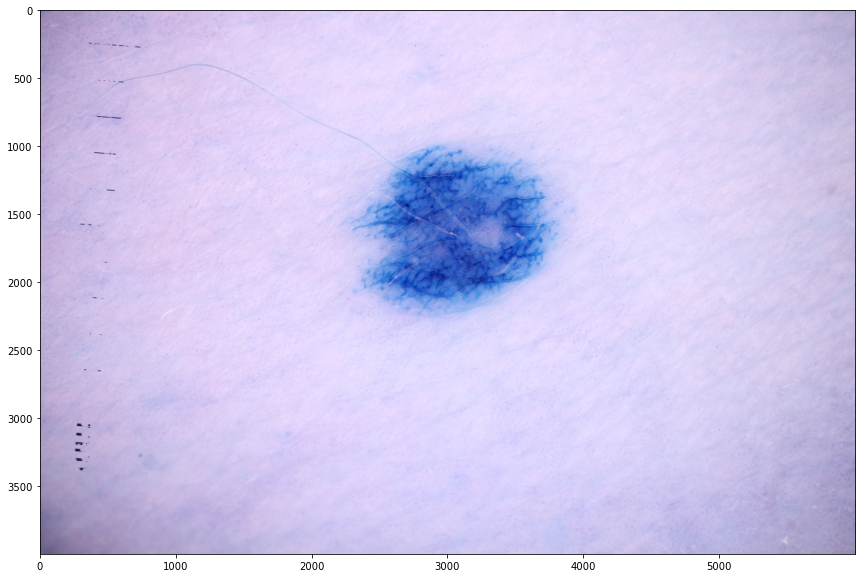

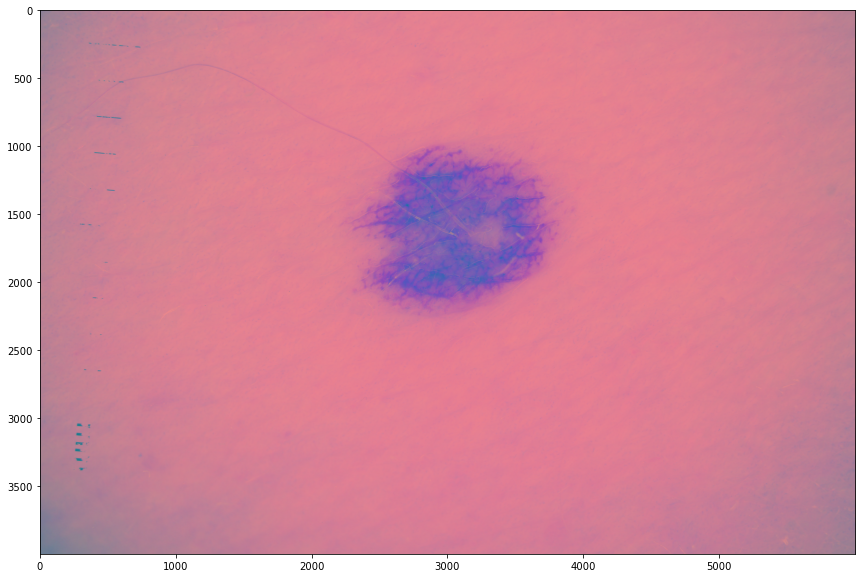

In [169]:
name = df.image_name[5]
image =  os.path.join(PATH_JPEG, f'{name}.jpg')
img = cv2.imread(image)
plt.imshow(img)
plt.show()
image =  os.path.join(PATH_DCM, f'{name}.dcm')
img = pydicom.dcmread(image)
plt.imshow(img.pixel_array)
plt.show()

In [167]:
#dir(img)

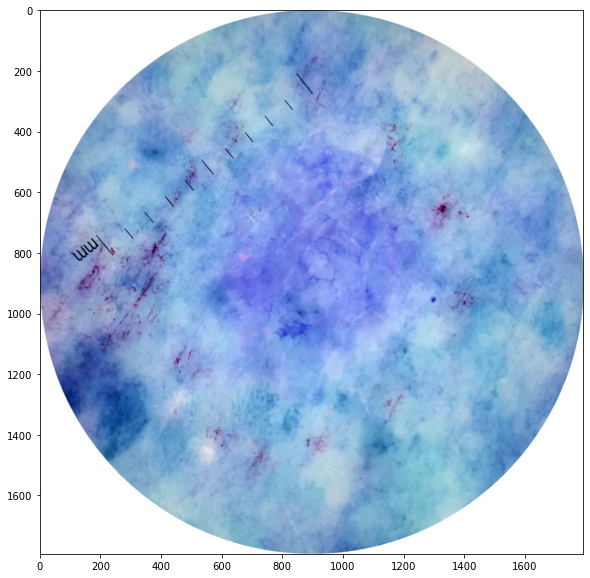

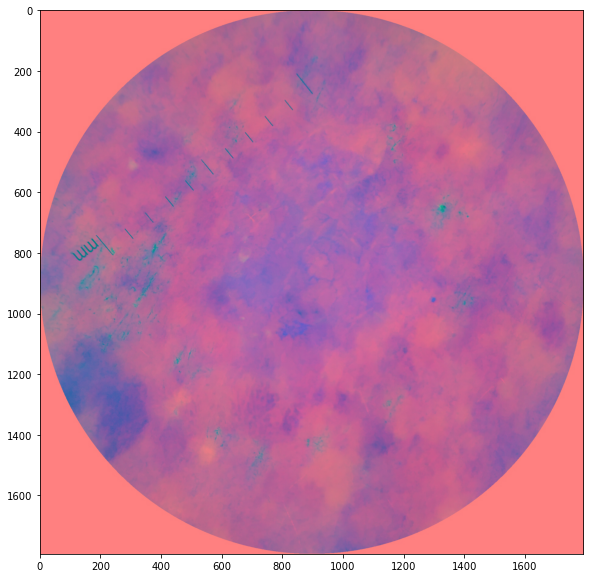

In [174]:
name = name = df[df.target == 1].image_name.values[20]
image =  os.path.join(PATH_JPEG, f'{name}.jpg')
img = cv2.imread(image)
plt.imshow(img)
plt.show()
image =  os.path.join(PATH_DCM, f'{name}.dcm')
img = pydicom.dcmread(image)
plt.imshow(img.pixel_array)
plt.show()

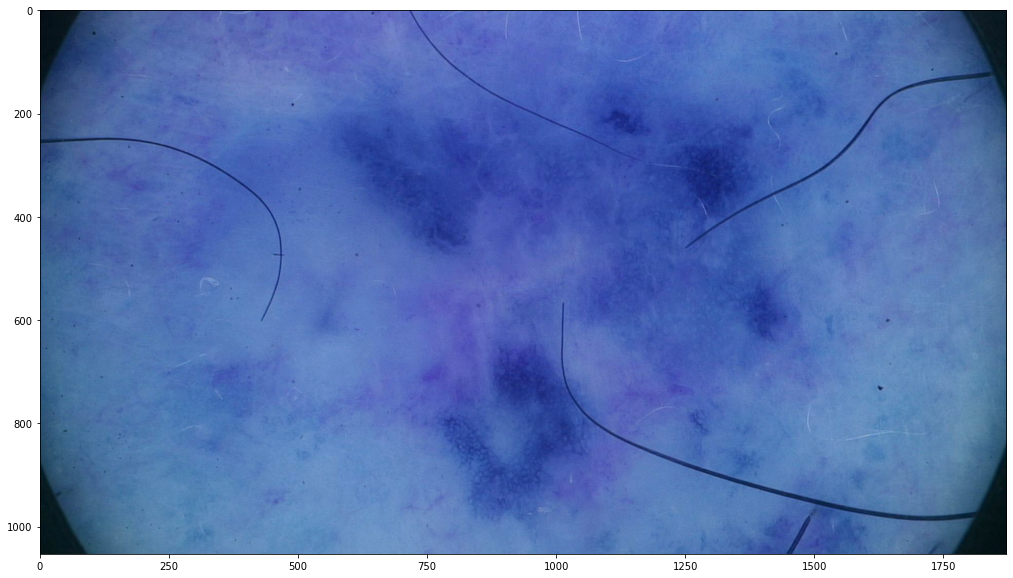

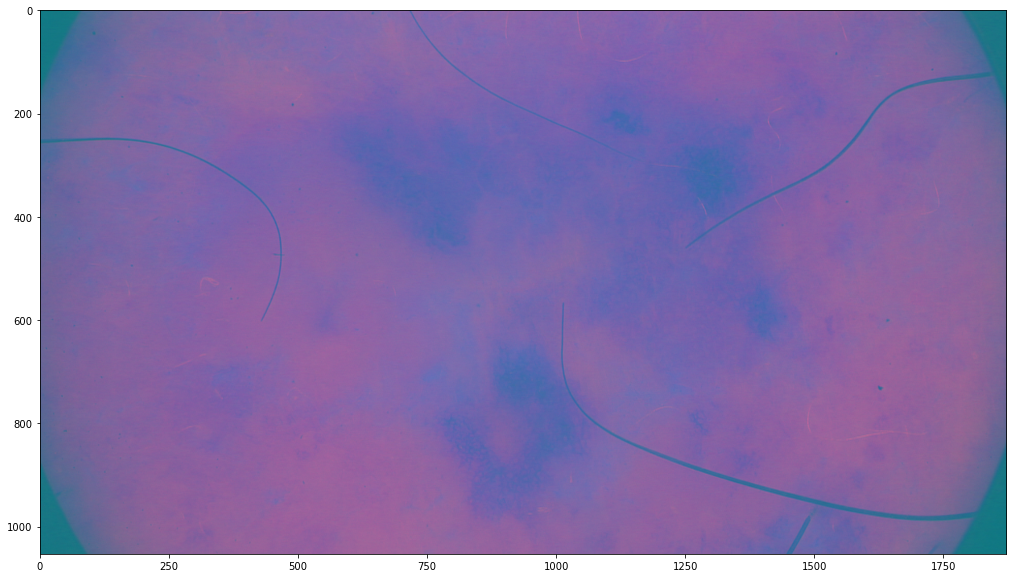

In [180]:
name = name = df[df.target == 1].image_name.values[130]
image =  os.path.join(PATH_JPEG, f'{name}.jpg')
img = cv2.imread(image)
plt.imshow(img)
plt.show()
image =  os.path.join(PATH_DCM, f'{name}.dcm')
img = pydicom.dcmread(image)
plt.imshow(img.pixel_array)
plt.show()

Изображения разного размера и формы
Визуально не отличить
Все центрированы

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


1. Делаем простую модель тест ну пусть будет 128*128
2. линейка на изображении именно она показывает где проблеммнй участок можно сделать по ней вырез
- берем изображение где есть размер относительно этого изображения и потом попробывать приминить к другим маштабируя в зависимости от изображения и поскольку оно центрировано и вырезать квадрат заданного размера.
